## Exploratory Data Analysis  Application_train and Application_test (EDA)



##  Overview

This notebook presents a comprehensive exploratory data analysis (EDA) of the Application dataset, which contains information about loan applicants and their repayment behavior. The primary objective is to uncover patterns, assess data quality, and identify features that influence credit risk.

The dataset includes **307,511 records** and **122 features**, with the target variable `TARGET` indicating whether an applicant **repaid (0)** or **defaulted (1)** on their loan. Given the binary nature of the target, this is a **classification problem** with a strong class imbalance.

##  Goals of This Analysis

- Understand the distribution and quality of both categorical and numerical features  
- Identify missing values, anomalies, and rare categories  
- Explore relationships between features and the target variable  
- Detect redundant or low-impact features  
- Prepare insights for feature selection and model development

##  Structure of the Notebook

- [ Data Loading and Preprocessing](#data-loading-and-preprocessing)
- [ Reduce memory](#reduce-memory)
- [ Missing Value Counts](#missing-value-counts)

- [ Distribution of the Target Variable](#distribution-of-the-target-variable)
  - [ Target Variable Imbalance](#target-variable-imbalance)

- [ Exploring Categorical Features](#exploring--categorical-features)
  - [ Categorical Feature Analysis — Part 1 Overview](#categorical-feature-analysis--part-1-overview)
  - [ Categorical Feature Analysis — Part 2 Overview](#categorical-feature-analysis--part-2-overview)
  - [ Categorical Feature Analysis — Part 3 Overview](#categorical-feature-analysis--part-3-overview)

- [ Numerical EDA](#numerical-eda)
- [ Low Variance Feature Filtering](#low-variance-feature-filtering)
  - [ Numerical Feature Distribution Analysis](#numerical-feature-distribution-analysis)
  - [ LOW-Correlated Numerical Features (PHI_K < 0.01)](#low-correlated-numerical-features-phi_k--001)

- [ Distribution Analysis of Top 10 Correlated Features](#distribution-analysis-of-top-10-correlated-features)
  - [ EXT_SOURCE Features](#numerical-feature-distribution-analysis--ext_source-features)
  - [ AGE Overview](#age-overview)
  - [ DAYS_LAST_PHONE_CHANGE](#days_last_phone_change)
  - [ DAYS_EMPLOYED](#days_employed)
  - [ Anomaly Investigation: DAYS_EMPLOYED ≈ -1001 Years](#anomaly-investigation-days_employed--1001-years)
  - [ Last feature distribution](#last-feature-distribution)
  - [ Overview last of 10 most correlated features](#overview-last-of-10-most-correlated-features)

- [ Independed Feature Correlation Analysis](#independed-feature-correlation-analysis)
  - [ Categorical independed feature corelations](#categorical-independed-feature-corelations)
  - [ Numerical indenpent feature correlation](#numerical-indenpent-feature-correlation)

- [ Statistical Testing of Numerical Features](#statistical-testing-of-numerical-features)
- [ Summary of Exploratory Data Analysis](#summary-of-exploratory-data-analysis)


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns


from src.utils.eda_utils import (
    outliers_counts,
    reduce_memory_usage_pl,
    PhikCorrelationChecker,
    get_missing_percentages,
    get_categorical_columns,
    get_numerical_columns
)
from src.utils.plot_utils import (
    draw_heatmap,
    barplot_feature_vs_target,
    plot_feature_vs_target_and_distribution,

)

## Data Loading and Preprocessing

In [4]:
application_train = pl.read_csv("../data/application_train.csv")
application_test = pl.read_csv("../data/application_test.csv")

I've loaded the main data tables, application_train and application_test, which contain the core details of each loan application.
Next, I will check the first rows of my train and test datasets.

In [5]:
application_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100002,1,"""Cash loans""","""M""","""N""","""Y""",0,202500.0,406597.5,24700.5,351000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,"""Laborers""",1.0,2,2,"""WEDNESDAY""",10,0,0,0,…,0.0,"""reg oper account""","""block of flats""",0.0149,"""Stone, brick""","""No""",2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,"""Cash loans""","""F""","""N""","""N""",0,270000.0,1293502.5,35698.5,1.1295e6,"""Family""","""State servant""","""Higher education""","""Married""","""House / apartment""",0.003541,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,"""Core staff""",2.0,1,1,"""MONDAY""",11,0,0,0,…,0.01,"""reg oper account""","""block of flats""",0.0714,"""Block""","""No""",1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,"""Revolving loans""","""M""","""Y""","""Y""",0,67500.0,135000.0,6750.0,135000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,"""Laborers""",1.0,2,2,"""MONDAY""",9,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,312682.5,29686.5,297000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Civil marriage""","""House / apartment""",0.008019,-19005,-3039,-9833.0,-2437,null,1,1,0,1,0,0,"""Laborers""",2.0,2,2,"""WEDNESDAY""",17,0,0,0,…,null,null,null,null,null,null,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
100007,0,"""Cash loans""","""M""","""N""","""Y""",0,121500.0,513000.0,21865.5,513000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Single / not married""","""House / apartment""",0.028663,-19932,-3038,-4311.0,-3458,null,1,1,0,1,0,0,"""Core staff""",1.0,2,2,"""THURSDAY""",11,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
application_train.shape

(307511, 122)

In Dataset consist of 307511 rows and 122 entries 
Output Column - TARGET (0 or 1) -  Binary Classification problem
Target 0 - Applicant repaied the credit amount
Target 1 - Applicant was not repaied the credit amount

In [7]:
application_test.head()

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100001,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,568800.0,20560.5,450000.0,"""Unaccompanied""","""Working""","""Higher education""","""Married""","""House / apartment""",0.01885,-19241,-2329,-5170.0,-812,null,1,1,0,1,0,1,null,2.0,2,2,"""TUESDAY""",18,0,0,0,0,…,null,null,"""block of flats""",0.0392,"""Stone, brick""","""No""",0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,"""Cash loans""","""M""","""N""","""Y""",0,99000.0,222768.0,17370.0,180000.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.035792,-18064,-4469,-9118.0,-1623,null,1,1,0,1,0,0,"""Low-skill Laborers""",2.0,2,2,"""FRIDAY""",9,0,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,"""Cash loans""","""M""","""Y""","""Y""",0,202500.0,663264.0,69777.0,630000.0,null,"""Working""","""Higher education""","""Married""","""House / apartment""",0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,"""Drivers""",2.0,2,2,"""MONDAY""",14,0,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,"""Cash loans""","""F""","""N""","""Y""",2,315000.0,1.575e6,49018.5,1.575e6,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.026392,-13976,-1866,-2000.0,-4208,null,1,1,0,1,1,0,"""Sales staff""",4.0,2,2,"""WEDNESDAY""",11,0,0,0,0,…,0.0817,"""reg oper account""","""block of flats""",0.37,"""Panel""","""No""",0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,"""Cash loans""","""M""","""Y""","""N""",1,180000.0,625500.0,32067.0,625500.0,"""Unaccompanied""","""Working""","""Secondary / secondary special""","""Married""","""House / apartment""",0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,null,3.0,2,2,"""FRIDAY""",5,0,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null


In [8]:
application_test.shape

(48744, 121)

Next, check application train and test dataset having same columns

In [9]:

for i in application_train.columns:
    result = True
    test_col = application_test.columns
    if i  not in test_col:
        if i != 'TARGET':
            result = False
            break
print('Both train and test have same column name- '+str(result))

Both train and test have same column name- True


As expected, test dataset contains all the columns except the target label

## Reduce memory  

In [10]:

application_train= reduce_memory_usage_pl(application_train)
application_test = reduce_memory_usage_pl(application_test)


Size before reduction: 289.57 MB
Initial data types: Counter({Float64: 65, Int64: 41, String: 16})


Size before reduction: 289.57 MB
Initial data types: Counter({Float64: 65, Int64: 41, String: 16})


Size after reduction: 111.85 MB
Final data types: Counter({Float32: 65, Int8: 37, Categorical(ordering='physical'): 16, Int32: 2, Int16: 2})
Size before reduction: 45.49 MB
Initial data types: Counter({Float64: 65, Int64: 40, String: 16})
Size after reduction: 17.67 MB
Final data types: Counter({Float32: 65, Int8: 36, Categorical(ordering='physical'): 16, Int32: 2, Int16: 2})


This reduced the memory footprint of the training data from 289.57 MB to 111.85 MB and that of the test data from 45.49 MB to 17.67 MB.

##  Missing Value Counts

Missing values in a Dataset will affect model performances, to avoid that need to handle this problem for that I have various method , important method is Imputer for that first i need to check missing values details in this tables.

In [11]:
missing_data_train = get_missing_percentages(application_train)
missing_data_train.sort("missing_percentage", descending=True).head(30)

feature,missing_percentage
str,f64
"""COMMONAREA_AVG""",69.872297
"""COMMONAREA_MODE""",69.872297
"""COMMONAREA_MEDI""",69.872297
"""NONLIVINGAPARTMENTS_AVG""",69.432963
"""NONLIVINGAPARTMENTS_MODE""",69.432963
…,…
"""NONLIVINGAREA_MODE""",55.179164
"""NONLIVINGAREA_MEDI""",55.179164
"""ELEVATORS_AVG""",53.29598


In [12]:
missing_data_test = get_missing_percentages(application_test)
missing_data_test.sort("missing_percentage", descending=True).head(30)

feature,missing_percentage
str,f64
"""COMMONAREA_AVG""",68.71615
"""COMMONAREA_MODE""",68.71615
"""COMMONAREA_MEDI""",68.71615
"""NONLIVINGAPARTMENTS_AVG""",68.412523
"""NONLIVINGAPARTMENTS_MODE""",68.412523
…,…
"""NONLIVINGAREA_MEDI""",53.512227
"""ELEVATORS_AVG""",51.676104
"""ELEVATORS_MODE""",51.676104


Application train and test data set have simalar missing data. 30 features have  more then 49% missing data. I think use inputation or use  XGBoost and LithGBoost models who can work with misising data.

Next, converting data to pandas

In [13]:
app_train_df = application_train.to_pandas()
app_test_df = application_test.to_pandas()

In [14]:
categorical =  get_categorical_columns(application_train)
categorical


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [15]:
app_train_df[categorical].describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [16]:
cat_test =  get_categorical_columns(application_test)
app_test_df[cat_test].describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,48744,48744,48744,48744,47833,48744,48744,48744,48744,33139,48744,48744,15947,25125,24851,26535
unique,2,2,2,2,7,7,5,5,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,48305,32678,32311,33658,39727,24533,33988,32283,43645,8655,9751,10840,12124,24659,11269,26179


While reviewing the train and test datasets, I noticed that CODE_GENDER has different options. I decided to check the number of unique classes in both dataset

In [17]:
train_data_type = app_train_df.select_dtypes('category').apply(pd.Series.nunique)
test_data_type = app_test_df.select_dtypes('category').apply(pd.Series.nunique)
pd.DataFrame({'Train_Unique_value_count': train_data_type, 'Test_Unique_value_count':test_data_type})

,Train_Unique_value_count,Test_Unique_value_count
NAME_CONTRACT_TYPE,2,2
CODE_GENDER,3,2
FLAG_OWN_CAR,2,2
FLAG_OWN_REALTY,2,2
NAME_TYPE_SUITE,7,7
NAME_INCOME_TYPE,8,7
NAME_EDUCATION_TYPE,5,5
NAME_FAMILY_STATUS,6,5
NAME_HOUSING_TYPE,6,6
OCCUPATION_TYPE,18,18


Upon inspecting the dataset, I observed anomalies in the CODE_GENDER and NAME_INCOME_TYPE features. Specifically, CODE_GENDER includes an unusual value ('XNA'), and NAME_INCOME_TYPE contains a rare entry ('Maternity leave'). These features warrant further investigation.

In [18]:
train_gender = app_train_df['CODE_GENDER'].value_counts()
test_gender =  app_test_df['CODE_GENDER'].value_counts()

print(test_gender, train_gender)

CODE_GENDER
F    32678
M    16066
Name: count, dtype: int64 CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


In [19]:
train_income = app_train_df['NAME_INCOME_TYPE'].value_counts()
test_income =  app_test_df['NAME_INCOME_TYPE'].value_counts()
print(train_income,test_income)

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64 NAME_INCOME_TYPE
Working                 24533
Commercial associate    11402
Pensioner                9273
State servant            3532
Student                     2
Businessman                 1
Unemployed                  1
Name: count, dtype: int64


In [20]:
train_income = app_train_df['NAME_FAMILY_STATUS'].value_counts()
test_income =  app_test_df['NAME_FAMILY_STATUS'].value_counts()
print(train_income,test_income)



NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64 NAME_FAMILY_STATUS
Married                 32283
Single / not married     7036
Civil marriage           4261
Separated                2955
Widow                    2209
Name: count, dtype: int64


Due to the extremely low frequency of these categories, they may introduce noise or instability in the model. Removing them should help maintain consistency

## Distribution of the Target Variable

Next, let's examine how the target variable is distributed in the dataset. This will help us understand class balance and guide decisions for model evaluation and potential resampling techniques.

In [21]:

from src.utils.plot_utils import (
    plot_bar_with_percentage,
    plot_feature_vs_target_and_distribution,
    barplot_feature_vs_target
)

In [22]:
custom_palette = sns.color_palette(["#D89864", "#89ABC7"]) 

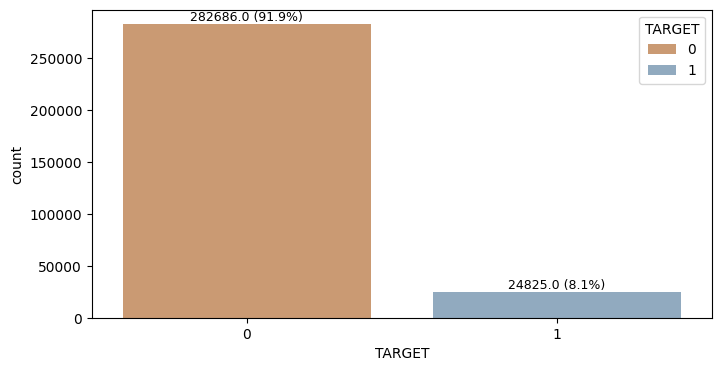

In [23]:
plot_bar_with_percentage(app_train_df, 'TARGET', palette=custom_palette)

### Target Variable Imbalance

From the count plot above, it's evident that the target variable is highly imbalanced:

- Number of applicants who repaid the loan: **282,686** (91.9%)
- Number of applicants who did not repay the loan: **24,825** (8.1%)

This imbalance should be taken into account during model training, as it may affect performance metrics and bias predictions toward the majority class.

---

## Exploring  Categorical Features

Next, let's examine the distribution of other categorical variables to identify potential anomalies, rare categories, or patterns that could influence model behavior.


NAME_CONTRACT_TYPE


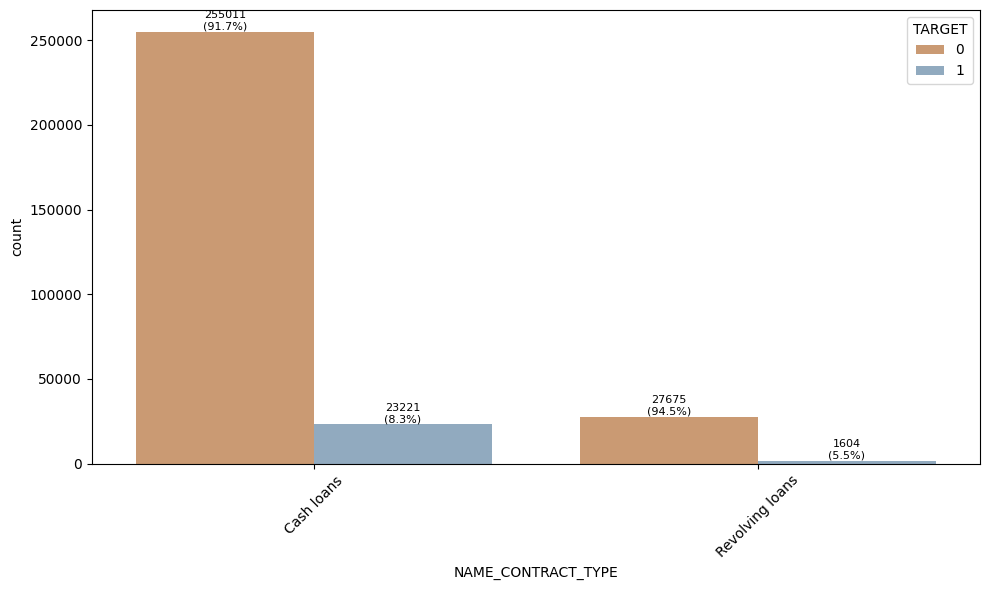

CODE_GENDER


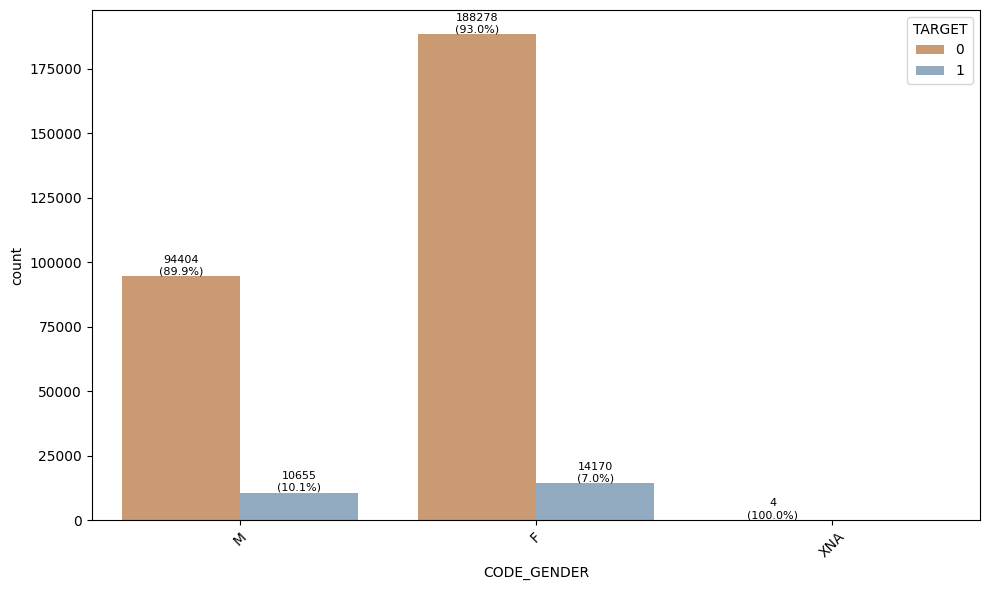

FLAG_OWN_CAR


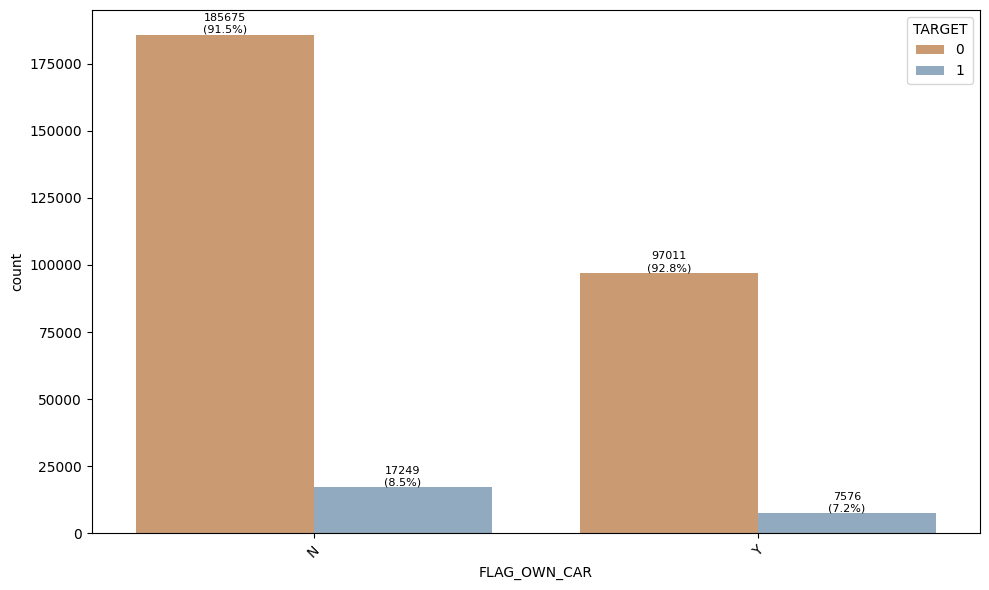

FLAG_OWN_REALTY


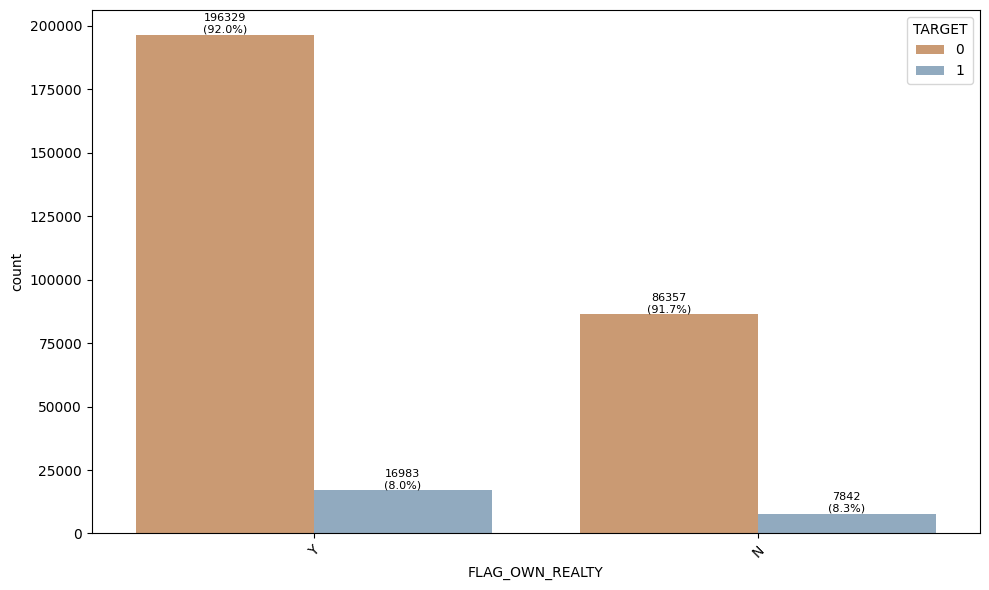

NAME_TYPE_SUITE


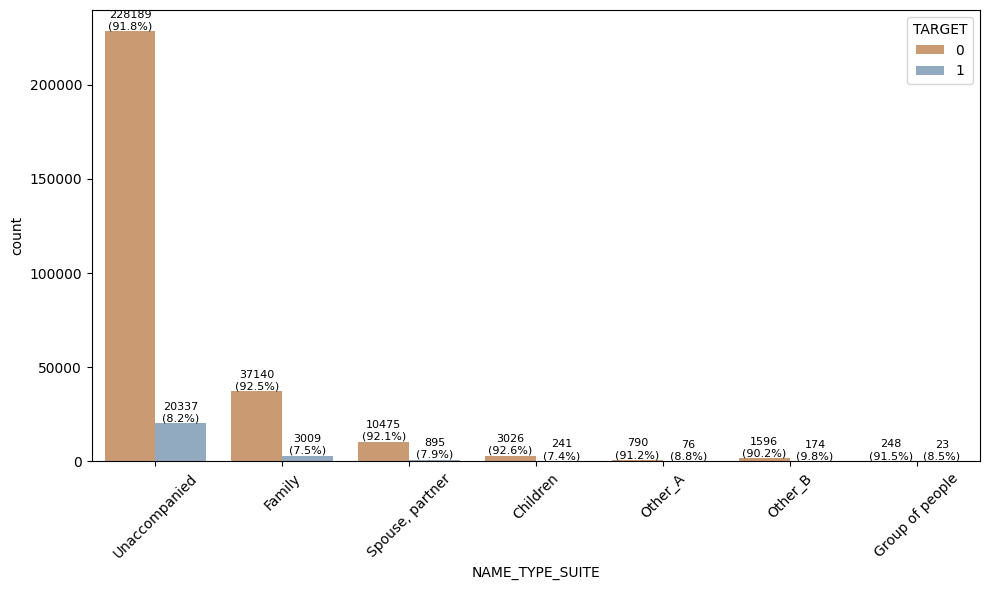

NAME_INCOME_TYPE


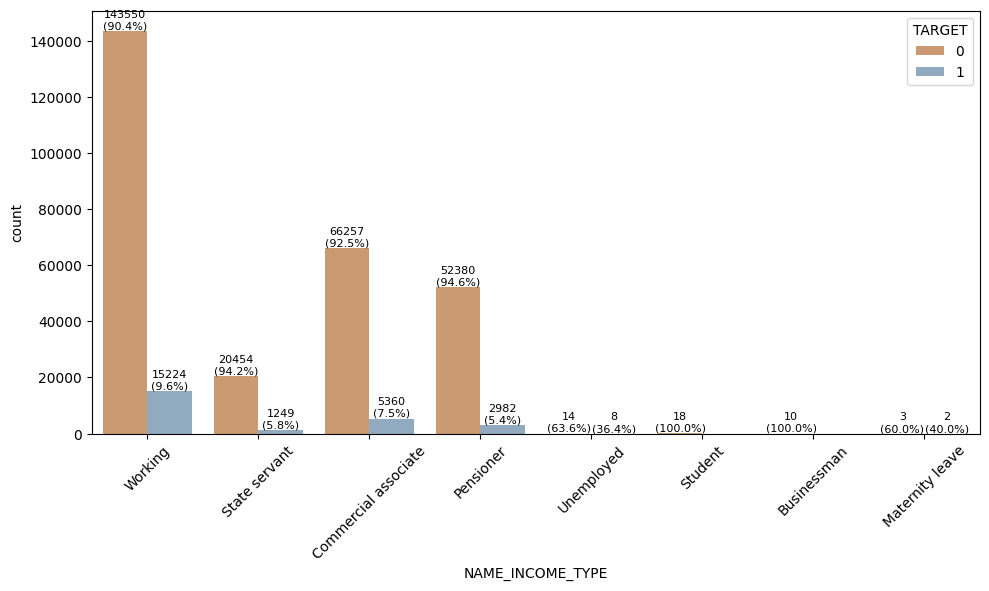

In [ ]:

for feature in app_train_df[categorical[:6]]:
    print(feature)
    barplot_feature_vs_target(
        target = 'TARGET',
        df=app_train_df,
        feature=feature,
        palette=custom_palette

        )


### Categorical Feature Analysis — Part 1 Overview

In this section, I explored several categorical features to understand their relationship with the target variable (`TARGET`) and identify any data quality issues or modeling implications.

### Key Findings:
- **Target Imbalance**: The dataset is highly imbalanced, with ~91.9% of applicants repaying their loans and only ~8.1% defaulting.
- **Rare Categories Identified**:
  - `CODE_GENDER`: Contains a rare value `'XNA'` with only 4 records — removed.
  - `NAME_INCOME_TYPE`: Includes `'Maternity leave'` with 5 records — removed.
  - Other features like `NAME_TYPE_SUITE` and `NAME_INCOME_TYPE` contain low-frequency categories that may be grouped or dropped.
- **Feature Insights**:
  - `FLAG_OWN_REALTY` and `FLAG_OWN_CAR`: Minor differences in default rates; retained for modeling.
  - `CODE_GENDER`: Females show slightly better repayment behavior.
  - `NAME_CONTRACT_TYPE`: Revolving loans have higher repayment rates than cash loans.
  - `NAME_TYPE_SUITE`: Most categories show similar behavior; rare ones may be grouped.
  - `NAME_INCOME_TYPE`: Pensioners and state servants show strong repayment; working class has higher default rate.

### Actions Taken:
- Removed rare categories with extremely low counts (`XNA`, `Maternity leave`).
- Documented repayment behavior across key categorical features.
- Flagged features for potential grouping or encoding in future preprocessing steps.

---

next, I examinate other features

NAME_EDUCATION_TYPE


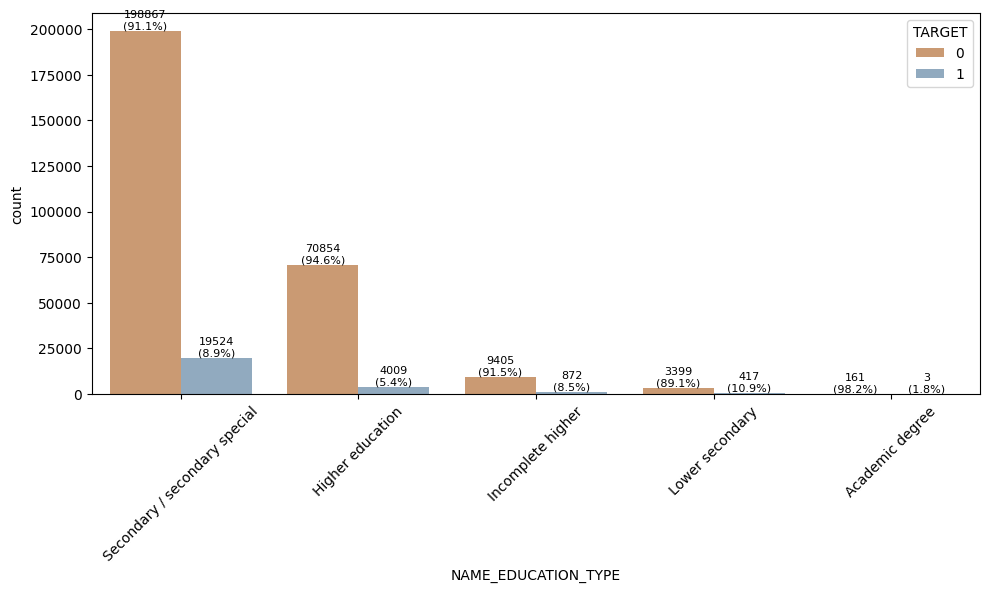

NAME_FAMILY_STATUS


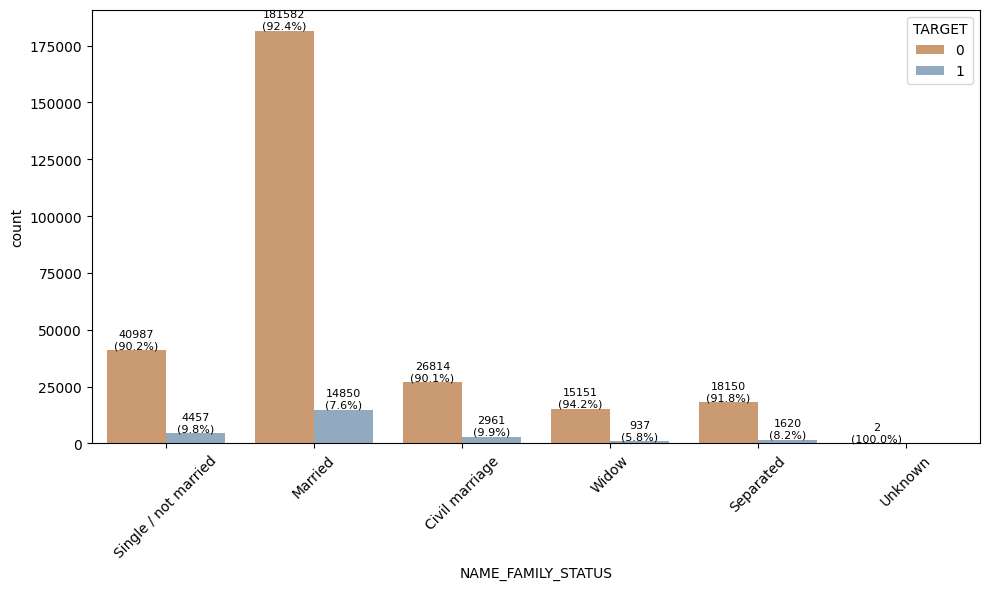

NAME_HOUSING_TYPE


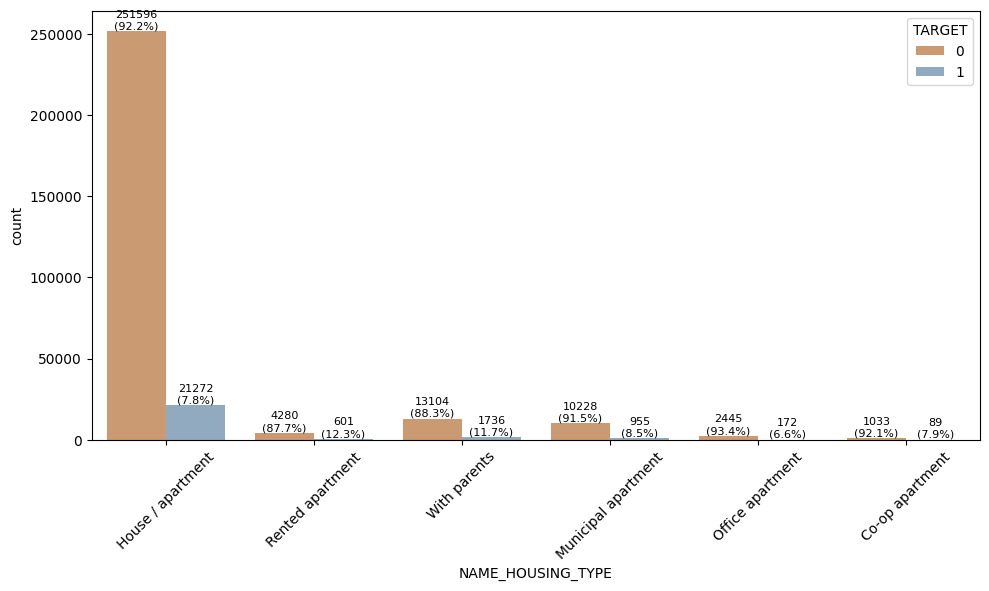

OCCUPATION_TYPE


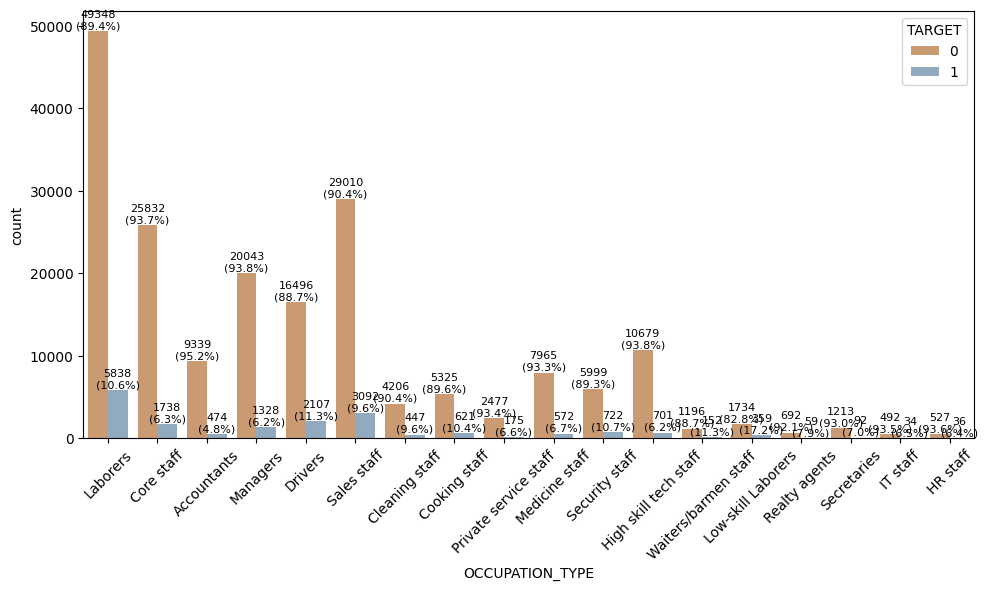

WEEKDAY_APPR_PROCESS_START


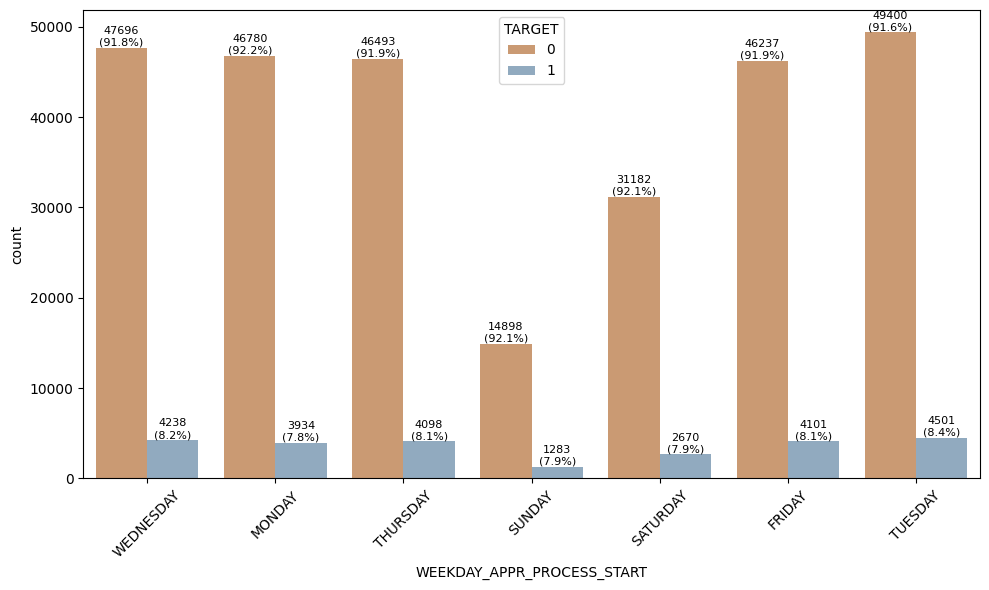

In [86]:
for feature in app_train_df[categorical[6:11]]:
    print(feature)
    barplot_feature_vs_target(
        target = 'TARGET',
        df=app_train_df,
        feature=feature,
        palette=custom_palette

        )

###  Categorical Feature Analysis — Part 2 Overview

This section continues the deep dive into categorical features, focusing on those with broader behavioral or socioeconomic implications. The goal remains the same: uncover patterns in repayment behavior, flag rare categories, and guide feature engineering decisions.

### Key Findings:
- **Education Matters**:
  - Applicants with **higher education** and **academic degrees** show the strongest repayment behavior.
  - **Lower secondary** education correlates with the highest default rate (10.9%).
  - Education level is a strong predictor and should be retained with possible grouping of rare categories.

- **Family Status Signals Stability**:
  - **Widowed** applicants have the highest repayment rate (94.2%), while **single** and **civil marriage** applicants show slightly elevated default rates (~9.8–9.9%).
  - Family status may reflect financial responsibility and support systems.

- **Housing Type Reflects Financial Security**:
  - Applicants living in **rented apartments** or **with parents** show higher default rates (~12%), suggesting lower asset ownership.
  - **House/apartment** dwellers dominate the dataset and show solid repayment behavior — useful as a baseline.

- **Occupation Type Is Highly Predictive**:
  - **Accountants**, **managers**, and **core staff** demonstrate strong repayment behavior.
  - **Low-skill laborers** and **waiters/barmen staff** show the highest default rates (up to 17.9%).
  - Occupation type is a powerful feature and may benefit from grouping based on risk tiers.

- **Weekday Application Timing Has Minimal Impact**:
  - Repayment rates are consistent across weekdays, ranging from 91.6% to 92.2%.
  - Slightly higher default rate on **Tuesdays** (8.4%) is likely not significant.
  - This feature may be retained but is unlikely to be a strong predictor.

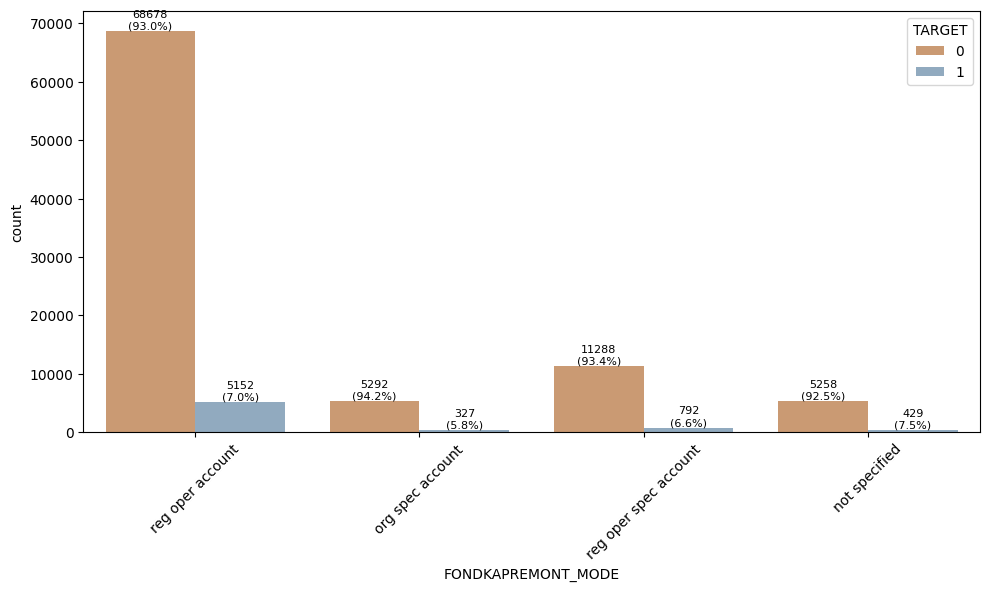

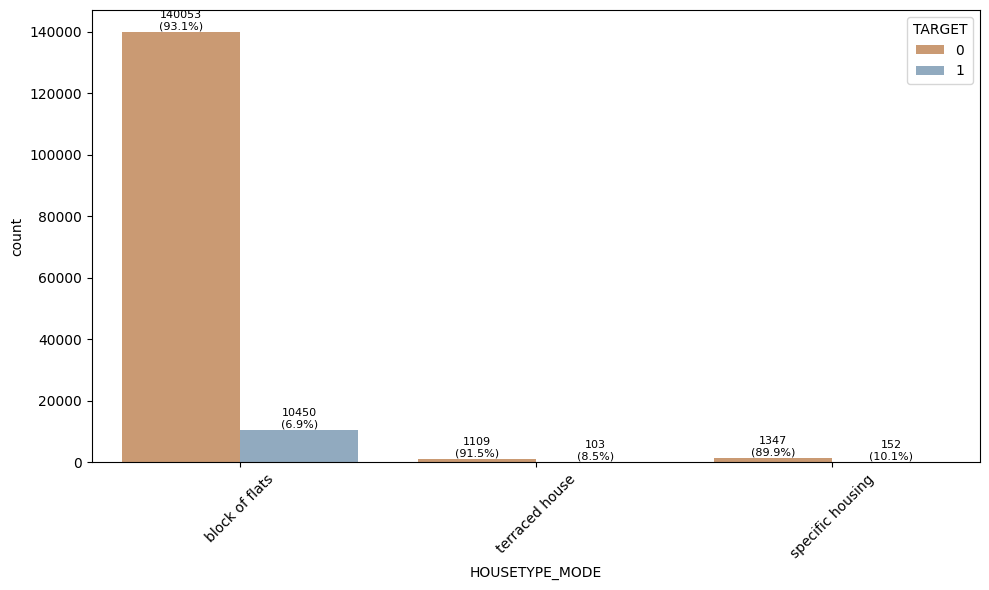

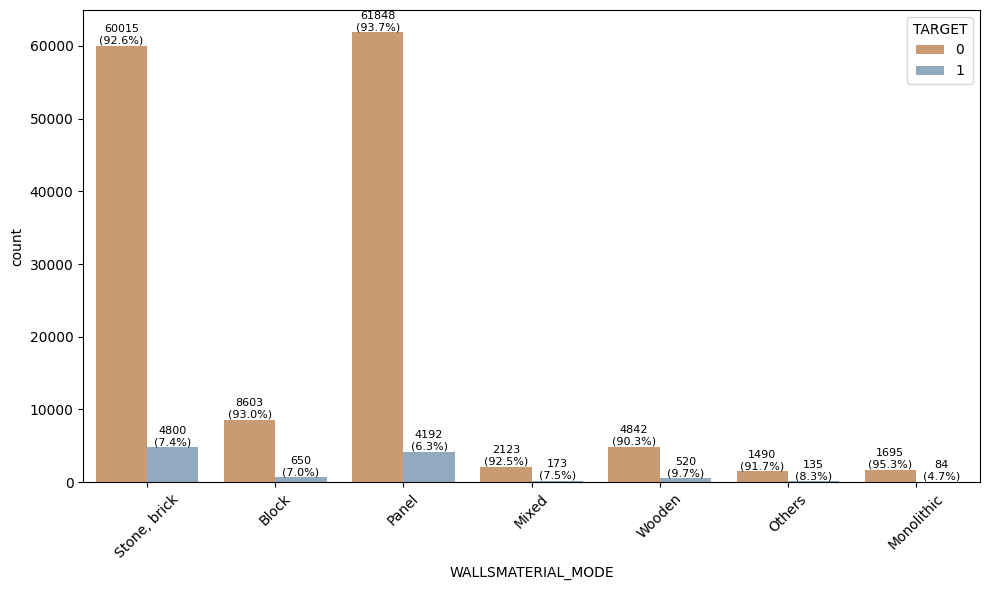

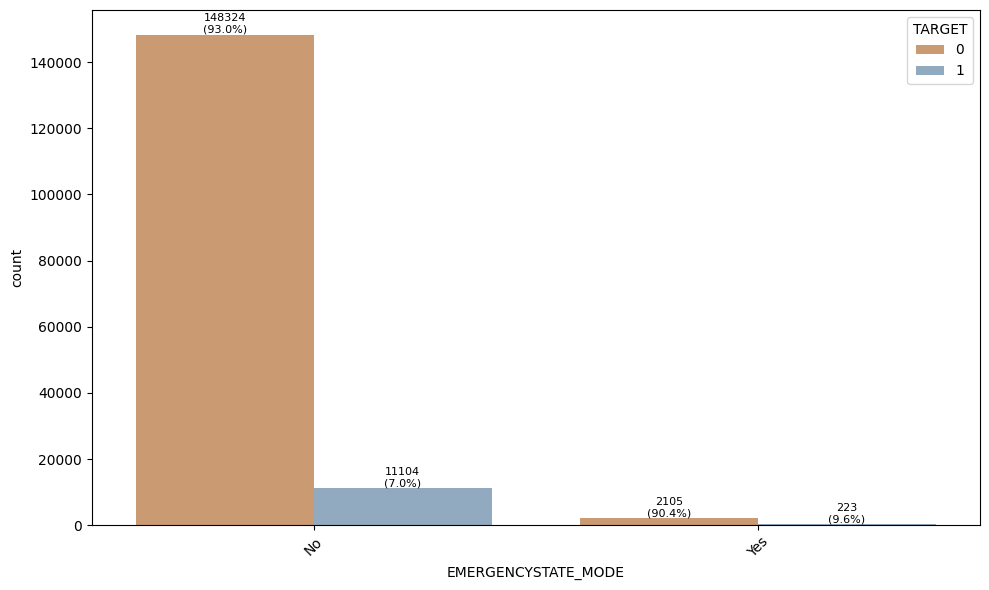

In [87]:
for feature in app_train_df[categorical[12:]]:
    barplot_feature_vs_target(
        target = 'TARGET',
        df=app_train_df,
        feature=feature,
        palette=custom_palette

        )

### Categorical Feature Analysis — Part 3 Overview

This section completes the categorical feature exploration by analyzing housing-related and infrastructure variables. These features offer insights into applicants’ living conditions and potential financial stress.

### Key Findings:
- **Housing Repair Funding (FONDKAPREMONT_MODE)**:
  - Slight differences in repayment behavior across categories.
  - `org spec account` shows the strongest repayment rate (94.2%).
  - `not specified` may reflect missing data and has the highest default rate (7.5%).

- **Housing Type (HOUSETYPE_MODE)**:
  - `Block of flats` is the dominant and most stable category.
  - `Specific housing` shows the highest default rate (10.1%), suggesting vulnerability.

- **Wall Material (WALLSMATERIAL_MODE)**:
  - `Monolithic` structures correlate with the lowest default rate (4.7%).
  - `Wooden` homes show the highest default rate (9.7%), possibly indicating older or lower-quality housing.

- **Emergency State (EMERGENCYSTATE_MODE)**:
  - Applicants in emergency housing have a higher default rate (9.6%).
  - This feature may reflect socioeconomic stress and should be retained.



## Numerical EDA

In this section, I will explore the distribution, central tendencies, and relationships of numerical features with the target variable (`TARGET`). This helps identify outliers, skewness, and potential predictors for modeling.


### Key Objectives:
- Understand the **distribution** of each numerical feature.
- Identify **outliers** and **skewed variables**.
- Examine **correlation** with the target variable.





**Summary Statistics**:
   - Use `.describe()` to get mean, std, min, max, and quartiles.
   - Check for extreme values or inconsistent ranges.

In [34]:
numerical_cols = get_numerical_columns(application_train)
print(len(numerical_cols))

106


In [35]:
app_train_df[numerical_cols].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.574219,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737305,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


From the describe() output, we can see that several features like FLAG_DOCUMENT_* and AMT_REQ_CREDIT_BUREAU_* behave like categorical variables with very few unique values. I’ve analyzed them and compiled a summary of features that have fewer than 3 unique values, which often means they’re binary or sparse categorical flags.

## Low Variance Feature Filtering

In [36]:
def find_integer_categorical_columns(df: pd.DataFrame, max_unique: int = 3) -> list:
    """
    Identifies numeric columns with a limited number of unique values,
    which are likely to be categorical.

    Parameters:
    - df: Input DataFrame
    - max_unique: Maximum number of unique values to consider as categorical (default = 3)

    Returns:
    - List of column names that are numeric and have <= max_unique unique values
    """
    int_cat_cols = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if df[col].nunique(dropna=True) <= max_unique:
            int_cat_cols.append(col)

    return int_cat_cols

In [37]:
limit_Unique = find_integer_categorical_columns(app_train_df)
print('Number of few values:',len(limit_Unique))

Number of few values: 35


In [38]:
limit_Unique

['TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [39]:
def convert_selected_numeric_to_categorical(df: pl.DataFrame, columns_to_convert: list) -> pl.DataFrame:
    new_cols = []
    for col in df.columns:
        if col in columns_to_convert:
            # First cast to string, then to categorical
            col_series = df[col].cast(pl.Utf8).cast(pl.Categorical)
        else:
            col_series = df[col]
        new_cols.append(pl.Series(name=col, values=col_series))

    return pl.DataFrame(new_cols)

In [40]:
application_train = convert_selected_numeric_to_categorical(application_train, limit_Unique)
cat_cols =  get_categorical_columns(application_train)
num_cols =get_numerical_columns(application_train)
print(len(num_cols), len(cat_cols))

71 51
 51




After reviewing the dataset, I identified **35 features** with low cardinality (fewer than 3 unique values). These were converted to **categorical** variables, as they likely represent flags or discrete indicators.

The remaining **71 features** were retained as **numerical** and will be used for continued exploratory analysis. These include continuous variables such as income, credit amounts, and time-based metrics.


### Numerical Feature Distribution Analysis

Next, I will examine the **distribution of the 71 numerical features** retained after feature type refinement. This step helps identify skewed variables, outliers, and potential candidates for transformation.


### Low Variance Feature Filtering

Before plotting distributions, I decided to check for **low-variance numerical features**. These features contribute little to data variability and may not provide meaningful insights during visualization or modeling.

By filtering out low-variance columns, I can:
- Reduce the number of plots.
- Focus on more informative features.
- Streamline the EDA process.

In [41]:

def get_low_variance_features(df: pd.DataFrame, threshold: float = 1e-5) -> list:
    """
    Identify numeric columns in a Pandas DataFrame with variance below a threshold.

    Parameters:
    - df: pd.DataFrame
    - threshold: float, minimum variance to keep a feature

    Returns:
    - List of column names with low variance
    """
    numeric_df = df.select_dtypes(include=['number'])
    variances = numeric_df.var()
    low_var_cols = variances[variances < threshold].index.tolist()
    return low_var_cols

In [42]:
low_var_features = get_low_variance_features(app_test_df[num_cols], threshold=0.01)
print("Low variance features:", len(low_var_features))

Low variance features: 24


In [43]:
numerical_df = app_train_df[num_cols]
numerical_df = numerical_df.drop(columns= low_var_features + ['SK_ID_CURR'] )

In [44]:
num_df = app_train_df[numerical_df.columns.to_list() + ['TARGET'] ]
num_df

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,0,202500.0,406597.5,24700.5,351000.0,-9461,-637,-3648.0,-2120,NaN,...,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,1.0,1
1,0,270000.0,1293502.5,35698.5,1129500.0,-16765,-1188,-1186.0,-291,NaN,...,0.0714,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0
2,0,67500.0,135000.0,6750.0,135000.0,-19046,-225,-4260.0,-2531,26.0,...,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0
3,0,135000.0,312682.5,29686.5,297000.0,-19005,-3039,-9833.0,-2437,NaN,...,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,0
4,0,121500.0,513000.0,21865.5,513000.0,-19932,-3038,-4311.0,-3458,NaN,...,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,-9327,-236,-8456.0,-1982,NaN,...,0.2898,0.0,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,0
307507,0,72000.0,269550.0,12001.5,225000.0,-20775,365243,-4388.0,-4090,NaN,...,0.0214,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0
307508,0,153000.0,677664.0,29979.0,585000.0,-14966,-7921,-6737.0,-5150,NaN,...,0.7970,6.0,0.0,6.0,0.0,-1909.0,1.0,0.0,1.0,0
307509,0,171000.0,370107.0,20205.0,319500.0,-11961,-4786,-2562.0,-931,NaN,...,0.0086,0.0,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,1


### Preparing for Correlation Analysis

With low-variance features removed, I now have a refined set of **numerical features**, including the target variable `TARGET`. The next step is to:

- Calculate **correlation coefficients** between each numerical feature and `TARGET`
- Visualize the results using a **correlation heatmap**
- Identify features with strong positive or negative correlation to `TARGET`
- Flag highly correlated feature pairs for potential dimensionality reduction

I use Phik Correlation

In [45]:
num_checker = PhikCorrelationChecker(
   num_df,
   target_col='TARGET'
)

In [46]:
num_corr = num_checker.get_correlations()

interval columns not set, guessing: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BUILD_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'YEARS_BUILD_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'APARTMENTS_MEDI', 'YEARS_BUILD_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']


In [47]:
sorted_corr = num_corr.sort_values(by='phik_correlation', ascending=False)
sorted_corr.head(10)


,feature,phik_correlation
14,EXT_SOURCE_3,0.247680
12,EXT_SOURCE_1,0.217846
13,EXT_SOURCE_2,0.213970
5,DAYS_BIRTH,0.102395
42,DAYS_LAST_PHONE_CHANGE,0.073215
6,DAYS_EMPLOYED,0.072096
8,DAYS_ID_PUBLISH,0.067769
4,AMT_GOODS_PRICE,0.059093
19,FLOORSMAX_AVG,0.058743
34,FLOORSMAX_MEDI,0.058445


In [48]:
sorted_corr.tail(20)

,feature,phik_correlation
11,HOUR_APPR_PROCESS_START,0.034577
22,APARTMENTS_MODE,0.033207
16,YEARS_BUILD_AVG,0.030880
23,YEARS_BUILD_MODE,0.030799
31,YEARS_BUILD_MEDI,0.030033
3,AMT_ANNUITY,0.029861
18,ENTRANCES_AVG,0.029770
33,ENTRANCES_MEDI,0.029705
28,LIVINGAPARTMENTS_MODE,0.027456
25,ENTRANCES_MODE,0.027089


### Insights
- **EXT_SOURCE features** are the strongest predictors — likely derived from external credit scoring systems.
- **Temporal features** like `DAYS_BIRTH`, `DAYS_EMPLOYED`, and `DAYS_LAST_PHONE_CHANGE` show meaningful behavioral patterns.
- **Housing-related features** (`FLOORSMAX_AVG`, `FLOORSMAX_MEDI`) may reflect socioeconomic status.
- Features with **PHI_K ≈ 0** likely have minimal predictive power and can be candidates for exclusion or dimensionality reduction.



### Zero-Correlated Numerical Features (PHI_K = 0.000)

The following numerical features show **zero PHI_K correlation** with the target variable, indicating no measurable statistical relationship — linear or non-linear — between them and the outcome:

- `OBS_30_CNT_SOCIAL_CIRCLE` → 0.000000  
- `OBS_60_CNT_SOCIAL_CIRCLE` → 0.000000  
- `AMT_REQ_CREDIT_BUREAU_QRT` → 0.000000  

These features may be:
- **Irrelevant** to the prediction task
- **Sparse or poorly distributed**, limiting their statistical signal
- **Redundant**, overlapping with other more informative variables

In [49]:
num_feature_top  = sorted_corr.head(10).feature
num_feature_top 

14              EXT_SOURCE_3
12              EXT_SOURCE_1
13              EXT_SOURCE_2
5                 DAYS_BIRTH
42    DAYS_LAST_PHONE_CHANGE
6              DAYS_EMPLOYED
8            DAYS_ID_PUBLISH
4            AMT_GOODS_PRICE
19             FLOORSMAX_AVG
34            FLOORSMAX_MEDI
Name: feature, dtype: object

In [50]:
num_corr[num_corr['phik_correlation'] <= 0.01].sort_values(by='phik_correlation', ascending=False)['feature'].to_list()

['DEF_30_CNT_SOCIAL_CIRCLE',
 'AMT_INCOME_TOTAL',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_QRT']

### LOW-Correlated Numerical Features (PHI_K < 0.01)

The following numerical features show **Low PHI_K correlation** with the target variable, indicating no measurable statistical relationship — linear or non-linear — between them and the outcome:

- `OBS_30_CNT_SOCIAL_CIRCLE`
- `OBS_60_CNT_SOCIAL_CIRCLE`  
- `AMT_REQ_CREDIT_BUREAU_QRT`
- `DEF_30_CNT_SOCIAL_CIRCLE`,
- `AMT_INCOME_TOTAL`,

## Distribution Analysis of Top 10 Correlated Features

After identifying the top 10 features most correlated with the target variable using PHI_K, we now examine their distributions to better understand their statistical properties and potential impact on modeling.

### Features Analyzed:
1. `EXT_SOURCE_3`
2. `EXT_SOURCE_1`
3. `EXT_SOURCE_2`
4. `DAYS_BIRTH`
5. `DAYS_LAST_PHONE_CHANGE`
6. `DAYS_EMPLOYED`
7. `DAYS_ID_PUBLISH`
8. `AMT_GOODS_PRICE`
9. `FLOORSMAX_AVG`
10. `FLOORSMAX_MEDI`


###  Goals of Distribution Analysis:
- Detect **skewness** or **non-normality** that may affect model performance
- Identify **outliers** or **missing values**
- Decide on **scaling**, **log transformation**, or **binning**
- Compare distributions across target classes


In [51]:
app_train_df['TARGET'].describe()

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

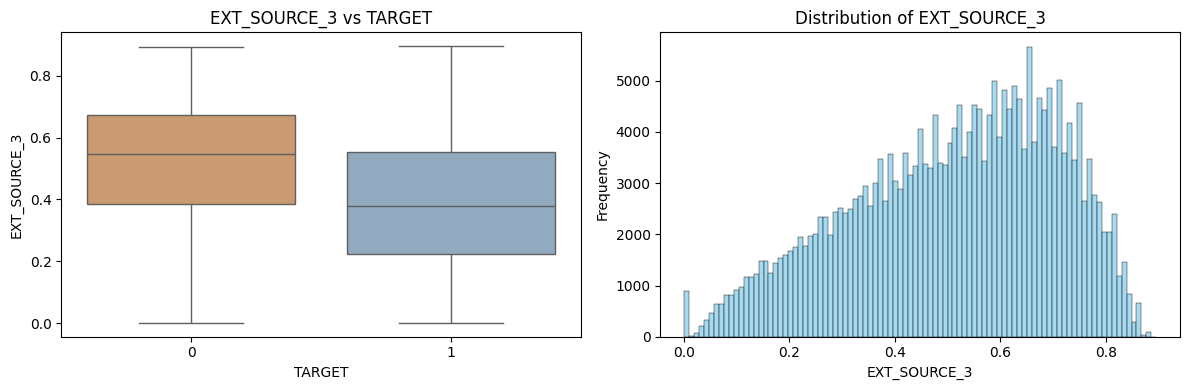

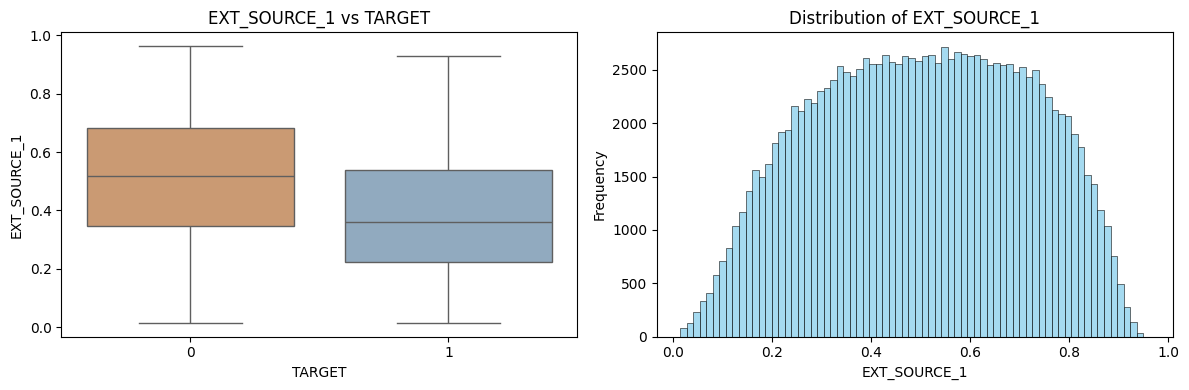

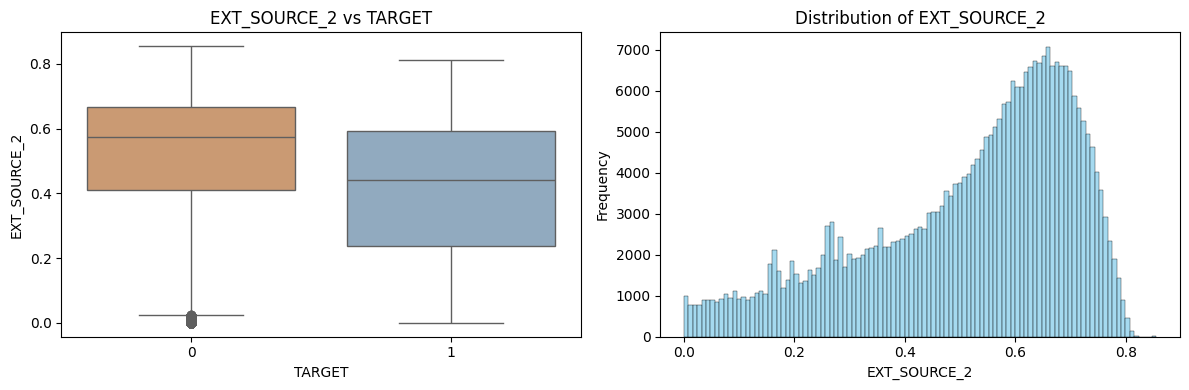

In [88]:

for feature in num_feature_top[:3]:

    plot_feature_vs_target_and_distribution(
        app_train_df,
        feature=feature,
        target='TARGET',
        palette=custom_palette,
    )


### Numerical Feature Distribution Analysis — EXT_SOURCE Features

This section analyzes the distribution of the three external source scores (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`). These features are normalized indicators of applicant reliability, often derived from third-party credit scoring systems.

### Key Findings:

#### 1. `EXT_SOURCE_3`
- **Distribution**: Right-skewed, values range from 0 to 1.
- **TARGET Separation**: Clear separation — lower values are more associated with `TARGET = 1`.
- **Interpretation**: Strong predictive signal. Higher scores indicate lower default risk.
- **Action**: Retain; consider binning or scaling for interpretability.

#### 2. `EXT_SOURCE_1`
- **Distribution**: Slightly skewed, with a concentration around 0.5.
- **TARGET Separation**: Moderate separation between classes; lower scores correlate with higher risk.
- **Interpretation**: Useful predictor, though less powerful than `EXT_SOURCE_3`.
- **Action**: Retain; may benefit from interaction with other features.

#### 3. `EXT_SOURCE_2`
- **Distribution**: Similar to `EXT_SOURCE_3`, but slightly flatter.
- **TARGET Separation**: Good separation — lower values more common among defaulters.
- **Interpretation**: Strong predictor, complements `EXT_SOURCE_3`.
- **Action**: Retain; consider combining with other EXT_SOURCE features for ensemble scoring.

### Summary Insights:
- All three EXT_SOURCE features show meaningful separation between repayment classes.
- These features are among the top-ranked by PHI_K correlation and tree-based importance.
- Their normalized scale and predictive power make them ideal for early modeling stages.

In [ ]:
app_train_df['DAYS_BIRTH'].describe()


count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Actually Age of applicant is in days format, for easy interpretation converting to age in to year format

In [ ]:
app_train_df['AGE'] = round(app_train_df['DAYS_BIRTH'] *-1/ 365)

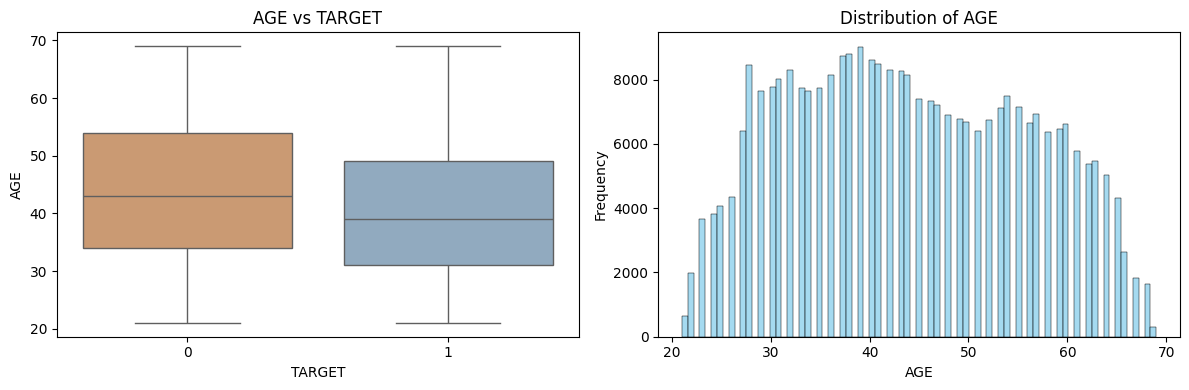

In [55]:
plot_feature_vs_target_and_distribution(
        app_train_df,
        feature='AGE',
        target='TARGET',
        palette=custom_palette,
    )

### AGE Overview

This section examines the age of applicants (converted from days to years) and its relationship to repayment behavior. The distribution plot reveals how age influences credit risk and guides feature engineering decisions.

### Key Findings:

- **Age Range**: Applicants span from approximately 20 to just under 70 years, with a median around 45.
- **TARGET Separation**: Clear distinction between repayment classes — younger applicants show higher default rates.
- **Risk Profile**: Defaulters tend to cluster in the 20s and 30s age range, while older applicants show more stable repayment behavior.



In [56]:
app_train_df['DAYS_LAST_PHONE_CHANGE'].describe()

count    307510.000000
mean       -962.858765
std         826.808472
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

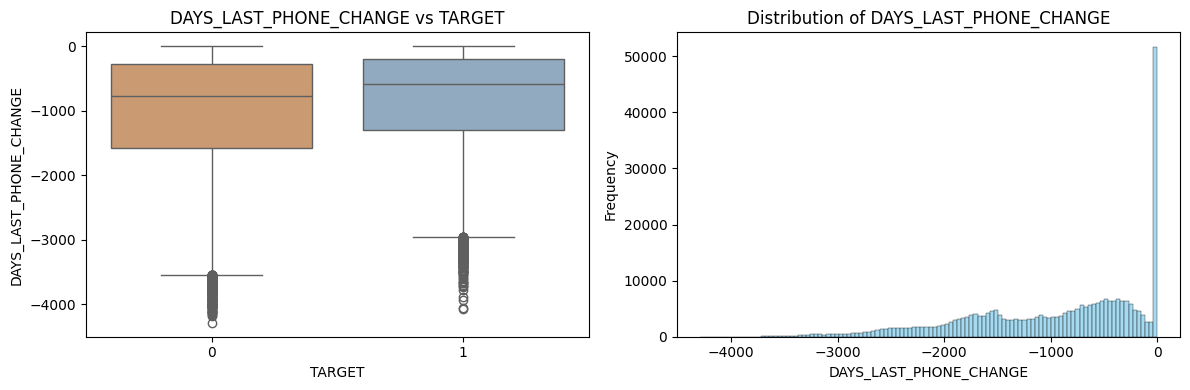

In [57]:
plot_feature_vs_target_and_distribution(
        app_train_df,
        feature='DAYS_LAST_PHONE_CHANGE',
        target='TARGET',
        palette=custom_palette,
    )

In [58]:
### DAYS_EMPLOYED

In [59]:
app_train_df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [60]:
app_train_df['year_changed'] = round(app_train_df['DAYS_LAST_PHONE_CHANGE'  ] *-1/ 365)

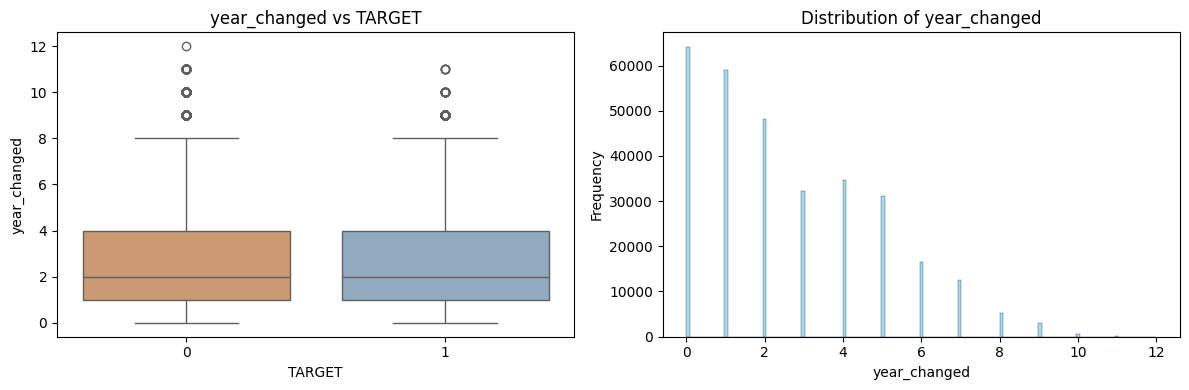

In [61]:
plot_feature_vs_target_and_distribution(
        app_train_df,
        feature='year_changed',
        target='TARGET',
        palette=custom_palette,
    )

### DAYS_LAST_PHONE_CHANGE

This feature represents the number of years since the applicant last changed their phone number. It serves as a behavioral indicator, potentially reflecting lifestyle stability or volatility. The distribution plots reveal patterns that may correlate with credit risk.

### Key Findings:

- **Tenure of Change**: Values range from 0 (recent change) to over 10 years, indicating a wide behavioral timeline.
- **TARGET Separation**: Both defaulters and non-defaulters peak around recent changes, but non-defaulters show more periodic spikes — suggesting structured or habitual updates.
- **Behavioral Insight**: The feature may reflect annual cycles or renewal patterns, especially among more stable applicants.

In [62]:
app_train_df['Year_Employed'] = round(app_train_df['DAYS_EMPLOYED'] *-1/ 365)

In [63]:
app_train_df['Year_Employed'].value_counts()

Year_Employed
-1001.0    55374
 1.0       34796
 2.0       30530
 3.0       27721
 4.0       22933
 5.0       19191
 6.0       15372
 7.0       14080
 8.0       12381
 9.0        9971
 0.0        9752
 10.0       8299
 11.0       6483
 12.0       5621
 13.0       4770
 14.0       4500
 15.0       3916
 16.0       2352
 17.0       2232
 18.0       1914
 19.0       1851
 20.0       1798
 21.0       1510
 22.0       1401
 23.0       1100
 24.0        950
 25.0        862
 26.0        727
 28.0        656
 27.0        638
 29.0        567
 30.0        512
 31.0        439
 32.0        390
 34.0        355
 33.0        352
 35.0        300
 36.0        207
 37.0        174
 38.0        128
 39.0        122
 40.0         82
 41.0         66
 42.0         44
 43.0         31
 45.0         27
 44.0         20
 46.0          7
 48.0          4
 47.0          2
 49.0          1
Name: count, dtype: int64

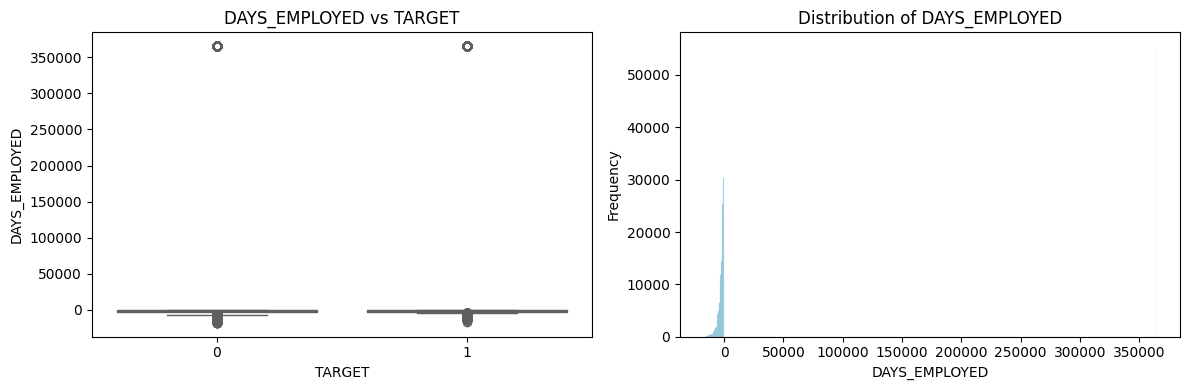

In [64]:
plot_feature_vs_target_and_distribution(
        app_train_df,
        feature='DAYS_EMPLOYED',
        target='TARGET',
        palette=custom_palette,
    )

### DAYS_EMPLOYED

This feature captures the number of days an applicant has been employed. It can reflect financial stability, career consistency, or data quality issues depending on its distribution.

### Key Findings

#### 1. **Outlier Detection**
- A sharp spike appears around **350,000 days** (~958 years), which is clearly unrealistic.
- This likely represents **missing or placeholder values** and should be flagged during preprocessing.

#### 2. **Box Plot Insights**
- Most values are concentrated at lower employment durations.
- Both TARGET=0 (non-defaulters) and TARGET=1 (defaulters) show similar distributions.
- Extreme outliers skew the visual range, masking subtle behavioral patterns.

#### 3. **Density Plot Insights**
- Majority of applicants have relatively short employment durations.
- Non-defaulters show a noticeable spike at the outlier value, suggesting placeholder values may be disproportionately assigned to this group.
- Defaulters have a smoother distribution, with fewer extreme values.


### Anomaly Investigation: DAYS_EMPLOYED ≈ -1001 Years

Next, we examine anomalies in the `DAYS_EMPLOYED` feature, specifically the extreme value around **-365,243 days** (~1001 years). This value is clearly unrealistic and likely represents missing or placeholder data.

#### Impact on TARGET:
- A significant portion of applicants with this anomalous value are concentrated in the **non-defaulting group (TARGET = 0)**.
- This suggests that the placeholder may have been systematically assigned to applicants with stable or unknown employment status.
- The anomaly introduces bias and should be handled carefully to avoid misleading model behavior.

In [65]:
anomal_emploed = app_train_df[app_train_df['DAYS_EMPLOYED'] ==365243]

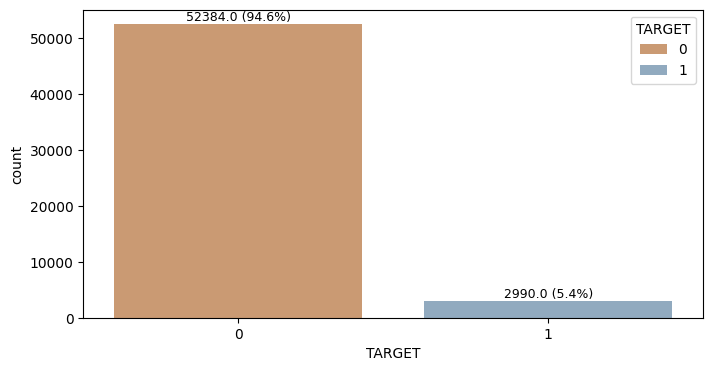

In [66]:

plot_bar_with_percentage(anomal_emploed, 'TARGET', palette=custom_palette)



Handling Anomalies in DAYS_EMPLOYED

The extreme value around **-365,243 days** (~1001 years) likely represents applicants who did **not provide valid employment information**. This placeholder appears frequently and does not reflect actual employment duration.

#### Preprocessing Strategy:
- Convert this anomalous value to `NaN` to ensure accurate statistical analysis.
- This transformation will allow cleaner visualizations and more reliable modeling.
- Consider creating a binary flag (e.g., `IS_EMPLOYED_MISSING`) to retain the signal of missing employment data.

### Last feature distribution

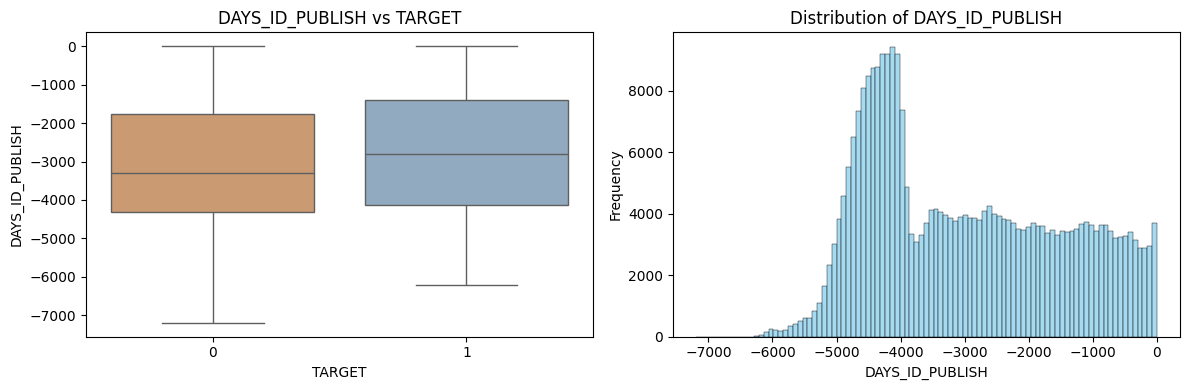

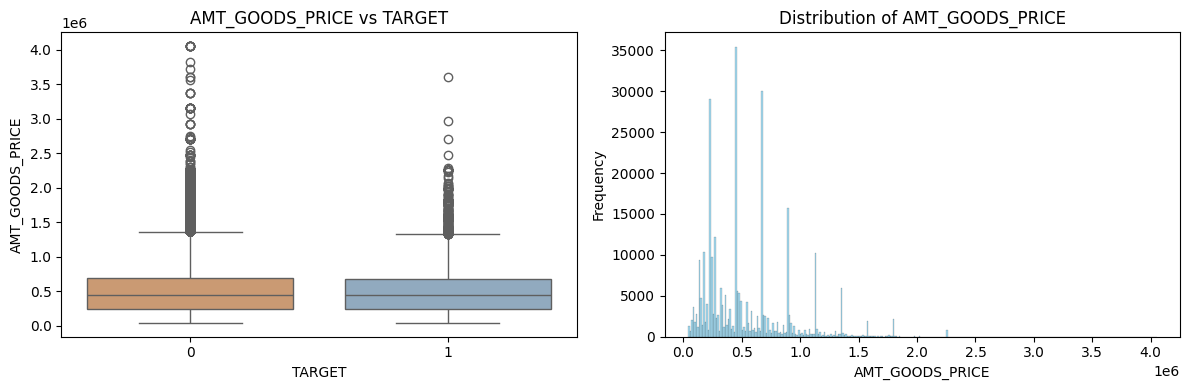

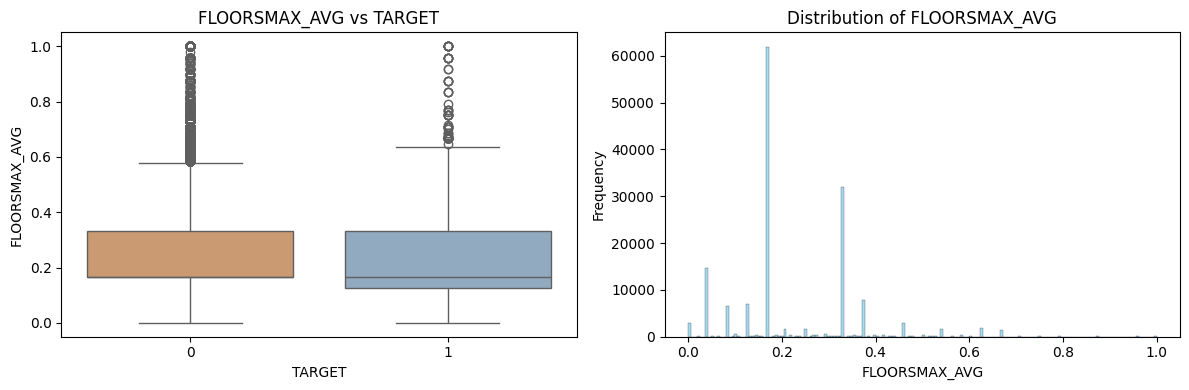

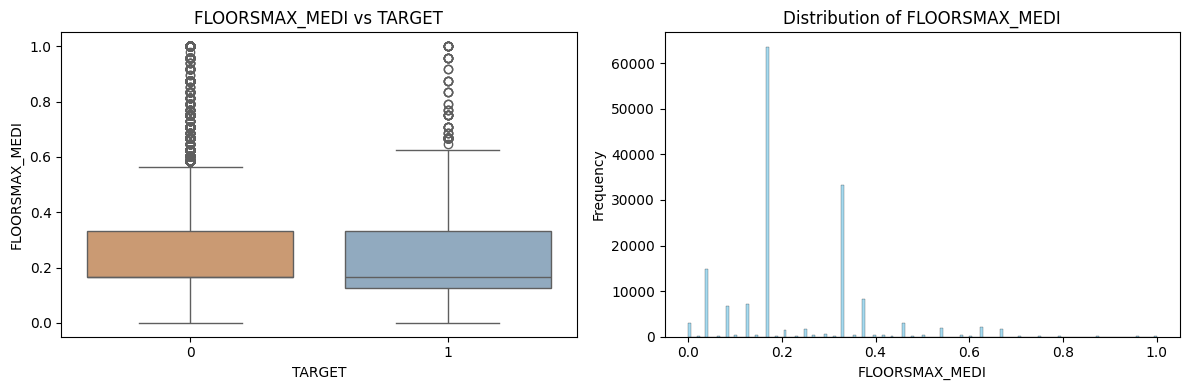

In [89]:
for feature in num_feature_top[6:]:

    plot_feature_vs_target_and_distribution(
        app_train_df,
        feature=feature,
        target='TARGET',
        palette=custom_palette,
    )

### Overview last of 10 most correlated features

This section consolidates insights from four features that reflect applicant documentation history, loan-related purchase behavior, and residential environment. While individually subtle in predictive strength, they may contribute to compound signals when used in interaction terms or grouped feature sets.

###  DAYS_ID_PUBLISH
- Represents the number of days since the applicant’s ID was last updated.
- Both TARGET groups show similar distributions, with peaks around -5000 days.
- Low discriminative power on its own, but may reflect administrative behavior or document recency.
- Potential value in interaction with application timing or other temporal features.

###  AMT_GOODS_PRICE
- Indicates the price of goods tied to the loan.
- Distribution is multi-modal, with peaks at standardized price points (e.g., 450k, 600k).
- Non-defaulters show sharper peaks, suggesting more structured purchasing behavior.
- Weak standalone signal; consider binning into price tiers or combining with credit amount.

###  FLOORSMAX_AVG
- Average maximum number of floors in the applicant’s building.
- Multi-modal distribution with common peaks at 1–3 floors.
- Minimal TARGET separation; may reflect urban density or housing type.
- Useful in clustering or location-based segmentation.

###  FLOORSMAX_MEDI
- Median number of floors in the applicant’s building.
- Defaulters show a flatter distribution, indicating more diverse housing environments.
- Slightly more outliers among defaulters, but overall weak predictive signal.
- May enhance socioeconomic profiling when combined with other housing features.



## Independed feature correlation analysis

After completing the numerical analysis, return to perform a correlation check among independent features to identify potential multicollinearity and feature redundancy.

In [68]:
num_cols = num_df.columns.to_list()

### Categorical independed feature corelations

In [69]:
cat_checker_  = PhikCorrelationChecker(
    app_train_df[cat_cols],
    target_col='TARGET'
)

In [70]:
cat_corr = cat_checker_.get_correlations()

interval columns not set, guessing: ['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


In [71]:
sorted_corr_cat = cat_corr.sort_values(by='phik_correlation', ascending=False)
sorted_corr_cat.head(10)


,feature,phik_correlation
15,OCCUPATION_TYPE,0.102846
25,ORGANIZATION_TYPE,0.089164
5,NAME_INCOME_TYPE,0.084831
23,REG_CITY_NOT_WORK_CITY,0.079951
10,FLAG_EMP_PHONE,0.072093
22,REG_CITY_NOT_LIVE_CITY,0.069579
31,FLAG_DOCUMENT_3,0.069522
7,NAME_FAMILY_STATUS,0.056043
8,NAME_HOUSING_TYPE,0.051107
24,LIVE_CITY_NOT_WORK_CITY,0.050950


OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY are some of the highest correlated categories with the TARGET variable.
 These maybe important in the classification task, and would need further EDA

In [72]:
weak_correlation = sorted_corr[sorted_corr['phik_correlation'] <= 0.001]
weak_correlation

,feature,phik_correlation
38,OBS_30_CNT_SOCIAL_CIRCLE,0.0
40,OBS_60_CNT_SOCIAL_CIRCLE,0.0
44,AMT_REQ_CREDIT_BUREAU_QRT,0.0


In [73]:
sorted_corr_cat[sorted_corr_cat['phik_correlation'] <= 0.01].sort_values(by='phik_correlation', ascending=False)['feature'].to_list()

['FLAG_DOCUMENT_15',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'REG_REGION_NOT_LIVE_REGION',
 'HOUSETYPE_MODE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_11',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_17',
 'LIVE_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_4',
 'FLAG_MOBIL',
 'FLAG_EMAIL',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20']

Low coreelated feature I remove from dataset.

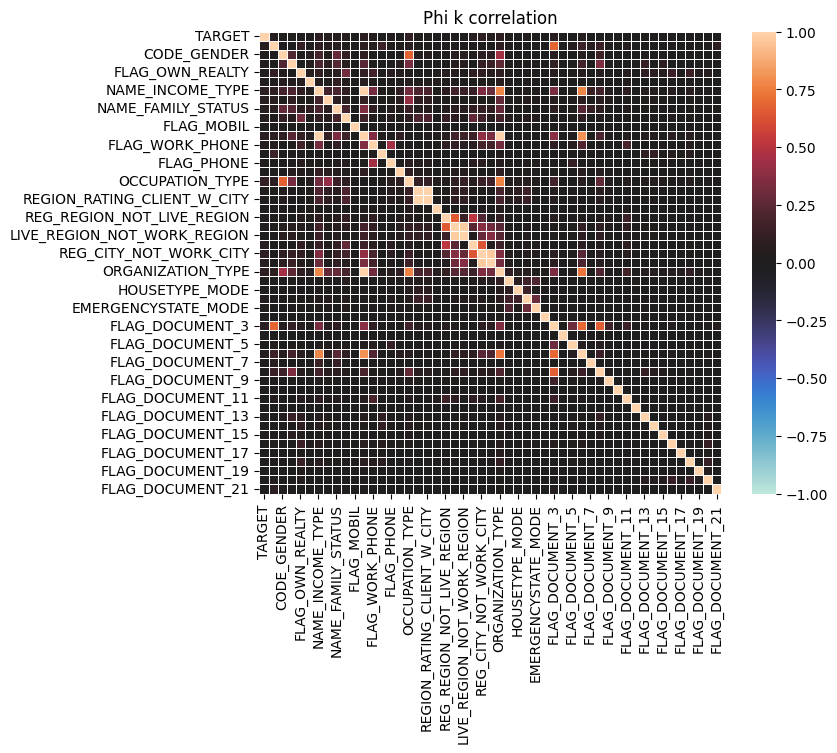

In [74]:
draw_heatmap(
    data=cat_checker_.phik_matrix,
    # annot=True,
    # annot_kws={'size':8},
    title='Phi k correlation',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="icefire",
    square=True)

In [75]:
independed_feature_corr = cat_checker_.get_feature_feature_correlations()

In [76]:
independed_feature_corr.sort_values(by='phik_correlation', ascending=False).head(20) 

,feature_1,feature_2,phik_correlation
289,NAME_INCOME_TYPE,FLAG_EMP_PHONE,1.000000
509,FLAG_EMP_PHONE,ORGANIZATION_TYPE,1.000000
714,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.998765
840,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,0.976119
924,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.962695
518,FLAG_EMP_PHONE,FLAG_DOCUMENT_6,0.806903
304,NAME_INCOME_TYPE,ORGANIZATION_TYPE,0.775917
313,NAME_INCOME_TYPE,FLAG_DOCUMENT_6,0.774436
689,OCCUPATION_TYPE,ORGANIZATION_TYPE,0.770229
983,ORGANIZATION_TYPE,FLAG_DOCUMENT_6,0.730549


## High Correlation Among Categorical Features

This section highlights categorical feature pairs with strong PHI_K correlations. These relationships may indicate redundancy, shared semantics, or hierarchical dependencies. Features with correlation ≥ 0.80 are flagged for review.

### Strongly Correlated Pairs (PHI_K ≥ 0.80)

| Feature 1                  | Feature 2                  | PHI_K Correlation |
|---------------------------|----------------------------|-------------------|
| NAME_INCOME_TYPE          | FLAG_EMP_PHONE             | 1.000             |
| FLAG_EMP_PHONE            | ORGANIZATION_TYPE          | 1.000             |
| REGION_RATING_CLIENT      | REGION_RATING_CLIENT_W_CITY| 0.998             |
| REG_REGION_NOT_WORK_REGION| LIVE_REGION_NOT_WORK_REGION| 0.976             |
| REG_CITY_NOT_WORK_CITY    | LIVE_CITY_NOT_WORK_CITY    | 0.963             |
| FLAG_EMP_PHONE            | FLAG_DOCUMENT_6            | 0.807             |



### Interpretation

- **Perfect Correlations (1.000)**: Suggest direct dependency or encoding overlap. Consider dropping one of the features or combining them.
- **Region & City Features**: High correlation between registration and living/work regions may indicate geographic redundancy.
- **Employment & Documentation**: Strong links between income type, organization, and document flags suggest overlapping administrative categories.


### Numerical indenpent feature correlation

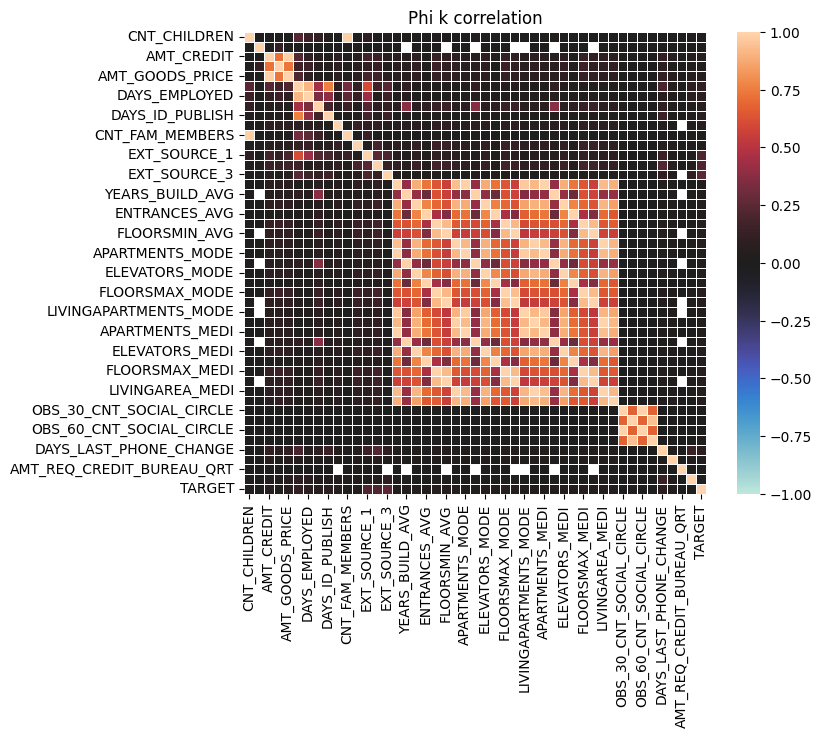

In [77]:
draw_heatmap(
    data=num_checker.phik_matrix,
    title='Phi k correlation',
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="icefire",
    square=True)

### 1.  Heatmap Observations
The heatmap visualizes the correlation between each feature and all others.  
- **Dark purplish tones** indicate low or no correlation.
- The overall dominance of purples suggests that **most features are not strongly correlated**, which is generally favorable for model diversity.

### 2. Target-Relevant Features
Among all features, the `EXT_SOURCE` variables show **strong correlation with the target** variable.  
These features are likely to be **highly predictive** and should be prioritized in the classification model.

### 3. Redundant Independent Features
Several independent features exhibit internal correlation due to their statistical nature (mean, median, mode).  

These features may carry **overlapping information**, and dimensionality reduction or feature selection may be beneficial.


### 4. Financial Feature Correlation
The features `AMT_CREDIT` and `AMT_GOODS_PRICE` are **highly correlated**.  
This suggests they may represent similar financial metrics and could introduce **multicollinearity**.

## Statistical Testing of Numerical Features

As the next step in numerical feature analysis, we apply statistical tests to evaluate whether each numerical feature is significantly associated with the target variable (`TARGET`).


###  Hypothesis Framework

- **Null Hypothesis (H₀):**  
  There is **no statistically significant relationship** between the feature and the target variable.  

- **Alternative Hypothesis (H₁):**  
  There **is a statistically significant relationship** between the feature and the target variable.  


###  Objective

To test all numerical features against the target variable using appropriate statistical methods (e.g., Mann–Whitney U test, or t-test), and identify which features show meaningful separation between classes.



###  Choose the Appropriate Statistical Test

Based on the results of the normality check, we select the appropriate test to evaluate the relationship between each numerical feature and the target variable (`TARGET`):

- **If the feature is normally distributed**:  
  Use the **Independent Samples t-test** to compare the means between the two target groups.

- **If the feature is not normally distributed**:  
  Use the **Mann–Whitney U test** to compare the distributions between the two target groups.



In [83]:
import scipy.stats as stats

def is_normal(data, alpha=0.05):
    """
    Check if data is normally distributed using D’Agostino and Pearson’s test.
    """
    if len(data) > 8:  
        _, p = stats.normaltest(data)
        return p > alpha
    else:
        return False  

def compare_groups(
    travel_df: pd.DataFrame, feature: str, target: str, alpha: float = 0.05
) -> pd.DataFrame:
    """
    Compare two groups for a specific feature using normality and statistical tests.

    Returns:
    - pd.DataFrame with columns:
      ['feature', 'Normality distributed (TARGET=0)', 'Normality distributed (TARGET=1)',
       'test_type', 'statistic', 'p_value']
    """
    group_0 = travel_df[travel_df[target] == 0][feature].dropna()
    group_1 = travel_df[travel_df[target] == 1][feature].dropna()

    normal_0 = is_normal(group_0, alpha)
    normal_1 = is_normal(group_1, alpha)

    if normal_0 and normal_1:
        test_type = "T-Test"
        stat, p_value = stats.ttest_ind(group_0, group_1)
    else:
        test_type = "Mann-Whitney U"
        stat, p_value = stats.mannwhitneyu(group_0, group_1, alternative="two-sided")
        
    result = {
        "feature": feature,
        "Normality distributed (TARGET=0)": normal_0,
        "Normality distributed (TARGET=1)": normal_1,
        "test_type": test_type,
        "statistic": stat,
        "p_value": round(p_value, 5)
    }

    return pd.DataFrame([result])

In [84]:
summary_rows = []

for feature in num_cols: 
    row_df = compare_groups(app_train_df, feature, 'TARGET')
    summary_rows.append(row_df)

full_summary_df = pd.concat(summary_rows, ignore_index=True)

c:\Users\steel\turing_projects\Capstone_v3\anplien-DS.v2.5.3.4.1\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1687: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis, _no_deco=True)
c:\Users\steel\turing_projects\Capstone_v3\anplien-DS.v2.5.3.4.1\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1792: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False, _no_deco=True)


In [ ]:
full_summary_df[full_summary_df['p_value'] >= 0.05]

,feature,Normality distributed (TARGET=0),Normality distributed (TARGET=1),test_type,statistic,p_value
3,AMT_ANNUITY,False,False,Mann-Whitney U,3.509236e+09,0.96756


In [ ]:
app_train_df['AMT_ANNUITY'].value_counts()

AMT_ANNUITY
9000.0     6385
13500.0    5514
6750.0     2279
10125.0    2035
37800.0    1602
           ... 
71424.0       1
54571.5       1
64759.5       1
4063.5        1
5841.0        1
Name: count, Length: 13672, dtype: int64

##  Statistical Interpretation

- Since both groups failed the normality check, the **Mann–Whitney U test** was used.
- The **p-value = 0.96756** is **much greater than 0.05**, so we **fail to reject the null hypothesis**.
- 🔍 **Conclusion**: There is **no statistically significant difference** in the distribution of `AMT_ANNUITY` between loan defaulters and non-defaulters.

## Summary of Exploratory Data Analysis

### Dataset Overview
- **Rows**: 307,511  
- **Features**: 122  
- **Target Variable**: `TARGET`  
  - `0`: Applicant repaid the loan  
  - `1`: Applicant defaulted  
- **Problem Type**: Binary Classification


## Missing Data Analysis
- 30+ features have **>49% missing values**  
- Train and test sets show **similar missingness patterns**  
- Recommended strategies:
  - Imputation
  - Use models like **XGBoost** or **LightGBM** that handle missing values natively


##  Target Variable Imbalance
- `TARGET = 0`: 282,686 applicants (91.9%)  
- `TARGET = 1`: 24,825 applicants (8.1%)  
- **Implication**: Strong imbalance — consider resampling or custom evaluation metrics



## Categorical Feature Analysis

### Rare & Anomalous Categories
- `CODE_GENDER`: Rare value `'XNA'` (4 records) → removed  
- `NAME_INCOME_TYPE`: Rare value `'Maternity leave'` (5 records) → removed  
- Other low-frequency categories flagged for grouping or removal

### Demographics & Loan Info
- `CODE_GENDER`: Females show slightly better repayment behavior  
- `NAME_CONTRACT_TYPE`: Revolving loans = higher repayment rates  
- `NAME_INCOME_TYPE`: Pensioners and state servants = low risk; working class = higher default  
- `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`: Minor differences — retained  
- `WEEKDAY_APPR_PROCESS_START`: Minimal impact; Tuesday shows slightly higher default

### Socioeconomic Indicators
- `NAME_EDUCATION_TYPE`:  
  - Higher education = strong repayment  
  - Lower secondary = highest default (10.9%)  
- `NAME_FAMILY_STATUS`:  
  - Widowed = most reliable  
  - Single/civil marriage = elevated risk  
- `NAME_HOUSING_TYPE`:  
  - Renting/living with parents = higher default (~12%)  
  - House/apartment = stable  
- `OCCUPATION_TYPE`:  
  - Accountants, managers = low risk  
  - Low-skill laborers, waiters = high risk (up to 17.9%)

###  Infrastructure & Living Conditions
- `FONDKAPREMONT_MODE`:  
  - `org spec account` = best repayment  
  - `not specified` = worst  
- `HOUSETYPE_MODE`:  
  - `Block of flats` = stable  
  - `Specific housing` = vulnerable  
- `WALLSMATERIAL_MODE`:  
  - `Monolithic` = lowest default (4.7%)  
  - `Wooden` = highest (9.7%)  
- `EMERGENCYSTATE_MODE`:  
  - Emergency housing = higher default (9.6%)

---

##  Numerical Feature Analysis

### Zero-Correlated Features (PHI_K = 0.000)
- `OBS_30_CNT_SOCIAL_CIRCLE`  
- `OBS_60_CNT_SOCIAL_CIRCLE`  
- `AMT_REQ_CREDIT_BUREAU_QRT`  
- **Action**: Likely irrelevant — consider dropping

### EXT_SOURCE Features
| Feature         | Distribution | Target Separation | Action |
|----------------|--------------|-------------------|--------|
| EXT_SOURCE_3    | Right-skewed | Strong            | Retain; consider binning |
| EXT_SOURCE_2    | Flat-normal  | Strong            | Retain; combine with EXT_SOURCE_3 |
| EXT_SOURCE_1    | Centered ~0.5| Moderate          | Retain; explore interactions |

###  Age (`DAYS_BIRTH`)
- Range: ~20 to ~70 years; median ~45  
- Younger applicants = higher default risk  
- **Action**: Retain; binning may improve interpretability

### DAYS_LAST_PHONE_CHANGE
- Recent changes common across both classes  
- Non-defaulters show structured update patterns  
- **Action**: Retain; explore cyclical or stability indicators

### DAYS_EMPLOYED
- Unrealistic value (~958 years) = placeholder  
- Placeholder mostly assigned to non-defaulters  
- **Action**:
  - Convert to `NaN`  
  - Create binary flag `IS_EMPLOYED_MISSING`

### Additional Features

| Feature             | Insight                                                                 | Action                        |
|---------------------|------------------------------------------------------------------------|-------------------------------|
| DAYS_ID_PUBLISH     | Low predictive power; may reflect admin behavior                        | Use in interactions           |
| AMT_GOODS_PRICE     | Multi-modal; structured purchasing among non-defaulters                 | Bin into price tiers          |
| FLOORSMAX_AVG       | Weak signal; may reflect urban density                                  | Use in clustering             |
| FLOORSMAX_MEDI      | Slightly flatter among defaulters; weak standalone signal               | Combine with housing features |

---

##  Feature Correlation Analysis

###  Strongly Correlated Categorical Pairs (PHI_K ≥ 0.80)

| Feature 1                  | Feature 2                  | PHI_K |
|---------------------------|----------------------------|--------|
| NAME_INCOME_TYPE          | FLAG_EMP_PHONE             | 1.000  |
| FLAG_EMP_PHONE            | ORGANIZATION_TYPE          | 1.000  |
| REGION_RATING_CLIENT      | REGION_RATING_CLIENT_W_CITY| 0.998  |
| REG_REGION_NOT_WORK_REGION| LIVE_REGION_NOT_WORK_REGION| 0.976  |
| REG_CITY_NOT_WORK_CITY    | LIVE_CITY_NOT_WORK_CITY    | 0.963  |
| FLAG_EMP_PHONE            | FLAG_DOCUMENT_6            | 0.807  |

**Action**: Review for redundancy; apply feature selection or dimensionality reduction

---
##  Low-Impact or Noisy Features

These 24 features show minimal variation, ambiguous categories, or weak predictive signal. They may introduce noise or redundancy:

- Examples include:  
  - `FLAG_DOCUMENT_2`, `FLAG_DOCUMENT_10`, `FLAG_DOCUMENT_12`  
  - `AMT_REQ_CREDIT_BUREAU_MON`, `AMT_REQ_CREDIT_BUREAU_WEEK`  
  - `OBS_30_CNT_SOCIAL_CIRCLE`, `OBS_60_CNT_SOCIAL_CIRCLE`  
  - `FLOORSMAX_AVG`, `FLOORSMAX_MEDI`, `FLOORSMAX_MODE`  
  - `LIVE_CITY_NOT_WORK_CITY`, `REG_CITY_NOT_WORK_CITY`  
  - `FLAG_MOBIL`, `FLAG_CONT_MOBILE`, `FLAG_WORK_PHONE`  
  - `FLAG_DOCUMENT_6`, `FLAG_DOCUMENT_7`, `FLAG_DOCUMENT_8`  
  - `NONLIVINGAPARTMENTS_MODE`, `NONLIVINGAPARTMENTS_MEDI`, `NONLIVINGAPARTMENTS_AVG`  
  - `BASEMENTAREA_MODE`, `BASEMENTAREA_MEDI`, `BASEMENTAREA_AVG`

**Action**: Consider dropping or aggregating based on modeling performance and feature selection results

## Recommended Next Steps
- Handle missing values and anomalies (e.g., DAYS_EMPLOYED)
- Address class imbalance in modeling
- Prioritize EXT_SOURCE features, AGE, OCCUPATION, and EDUCATION
- Drop or consolidate zero-correlated and redundant features
